In [36]:
import numpy as np,os
import skimage as sk
import skimage.io as skio
import matplotlib.pyplot as plt
import math
import imageio.v3 as iio

In [140]:
imname = 'extra_media/tree.jpg'
im = skio.imread(imname)
im = sk.img_as_float(im)

In [141]:
height = int(np.floor(im.shape[0] / 3.0))
#im.shape[height,width]
# separate color channels
b = im[:height,:]
g = im[height: 2*height,:]
r = im[2*height: 3*height,:]

In [31]:
#defining functions to use here
def euclidean_dist(a,b):
    return -math.sqrt(np.sum((a-b)**2)) #use -ve sign so higher euclidean => closer match

def ncc(a,b):
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 0.0 # dot pdt rule
    return float(np.sum(a * b, dtype=np.float64) / (na * nb))

def crop(img, margin=0.08):
    H, W = img.shape
    m = int(min(H, W) * margin)
    if m == 0:
        return img
    return img[m:H-m, m:W-m]

#for low res, use window slider to align based on pixel similarity. for high res, use pyramid function below
def align_low_res(move, ref, win=15, metric = "ncc"):
    H, W = ref.shape # assigning vars to tuple values
    if metric.lower() in ("euclidean", "l2"): # can choose between either method
        score_fn = euclidean_dist  
    else: 
        score_fn = ncc

    best_score = None
    best_shift = (0, 0)

    for dy in range(-win, win + 1):
        r0_ref = max(0,  dy); r1_ref = min(H, H + dy)
        if r1_ref <= r0_ref:
            continue

        for dx in range(-win, win + 1):
            c0_ref = max(0,  dx); c1_ref = min(W, W + dx)
            if c1_ref <= c0_ref:
                continue

            shifted = np.roll(np.roll(move, dy, axis=0), dx, axis=1)

            A = shifted[r0_ref:r1_ref, c0_ref:c1_ref]  # overlap from moved
            B = ref    [r0_ref:r1_ref, c0_ref:c1_ref]  # overlap from ref

            A = crop(A,0.08)
            B = crop(B,0.08) #cropping will give better results, makes such a big diff

            s = score_fn(A, B)
            if (best_score is None) or (s > best_score):
                best_score = s
                best_shift = (dy, dx)

    dy, dx = best_shift
    aligned = np.roll(np.roll(move, dy, axis=0), dx, axis=1)

    return best_shift, aligned, best_score


In [142]:
win = 15

(g_shift, g_aligned, _ ) = align_low_res(g, b, win=win, metric=metric)
(r_shift, r_aligned, _ ) = align_low_res(r, b, win=win, metric=metric)

print(f"Green Off-Set (dy, dx): {g_shift}")
print(f"Red Off-Set (dy, dx): {r_shift}")

Green Off-Set (dy, dx): (5, 0)
Red Off-Set (dy, dx): (15, 0)


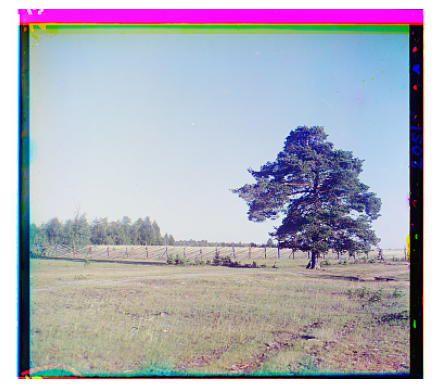

In [143]:
im_out = np.dstack([r_aligned, g_aligned, b])

plt.imshow(np.clip(im_out, 0, 1))
plt.axis("off")
plt.show()

In [144]:
os.makedirs("outputs", exist_ok=True)
iio.imwrite("outputs/aligned_full.png", (np.clip(im_out,0,1)*255).astype(np.uint8))

Implementing coarse to fine pyramid for images with higher resolution

In [50]:
#use rescale and sobel from skimage library
from skimage.transform import rescale
from skimage.filters import sobel

In [51]:
#some pre-processing to accomodate to images with varying brighness
def prep(img,mode="raw"):
    if mode == "grad":
        return sobel(img)
    return img

In [145]:
def pyramid(img,scale=0.5,coarse=200): #build from coarsest to finest, form is list
    pyra = [img]
    while min(pyra[-1].shape)>coarse:
        pyra.append(rescale(pyra[-1],scale,anti_aliasing=True, channel_axis=None))
    return pyra[::-1] #builds pyramid by appending larger images to list

#in rescale, scale<1 is downscaling
def align_pyramid(move, ref, *, win=15, metric="ncc", scale = 0.5, coarse = 200, mode="grad"):
    mov_pyr = pyramid(move, scale=scale, coarse=coarse)
    ref_pyr = pyramid(ref,  scale=scale, coarse=coarse)

    mov_pyr_proc = [prep(x, mode=mode) for x in mov_pyr]
    ref_pyr_proc = [prep(x, mode=mode) for x in ref_pyr]

    (dy, dx), _, _ = align_low_res(mov_pyr_proc[0], ref_pyr_proc[0], win=win, metric=metric)

    for lvl in range(1, len(mov_pyr_proc)):
        dy = int(round(dy / scale))
        dx = int(round(dx / scale))

        pre = np.roll(np.roll(mov_pyr_proc[lvl], dy, axis=0), dx, axis=1)
        local_win = max(4, win // (2 ** lvl))
        (ldy, ldx), _, _ = align_low_res(pre, ref_pyr_proc[lvl], win=local_win, metric=metric)
        dy += ldy
        dx += ldx

    aligned_full = np.roll(np.roll(move, dy, axis=0), dx, axis=1) # apply final shift to original full-res image
    return (dy, dx), aligned_full

In [146]:
metric = "ncc"
(g_shift, G_pyr) = align_pyramid(g, b, win=15, metric=metric, scale=0.5, coarse=200, mode="grad")
(r_shift, R_pyr) = align_pyramid(r, b, win=15, metric=metric, scale=0.5, coarse=200, mode="grad")

print("Pyramid shifts  G:", g_shift, " R:", r_shift)

Pyramid shifts  G: (5, 0)  R: (15, 0)


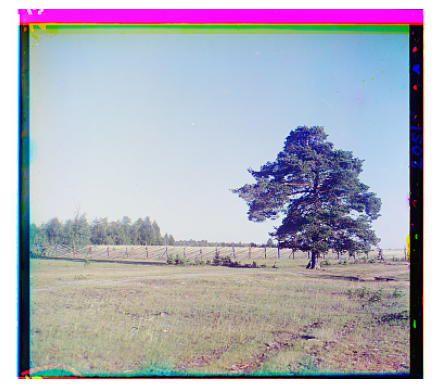

In [147]:
rgb_big = np.dstack([R_pyr, G_pyr, b])
plt.imshow(np.clip(rgb_big, 0, 1)); 
plt.axis("off")
plt.show()

In [129]:
os.makedirs("outputs", exist_ok=True)
iio.imwrite("outputs/aligned_full.png", (np.clip(rgb_big,0,1)*255).astype(np.uint8))